In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
from utils import get_camera_calib, get_perspective, Line

In [3]:
left_line = Line()
right_line = Line()
mtx, dist = get_camera_calib()
M, Minv = get_perspective()

In [4]:
# parameters to tune

# sobel gradient along x axis
sx_thresh = (32, 95)
# s color space threshold in HLS
# s_thresh = (160, 255)
s_thresh = (130, 255)

# number of windows in sliding window search
n_windows = 9
# reasonable change of pixels detected
peak_theta = 25

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 55


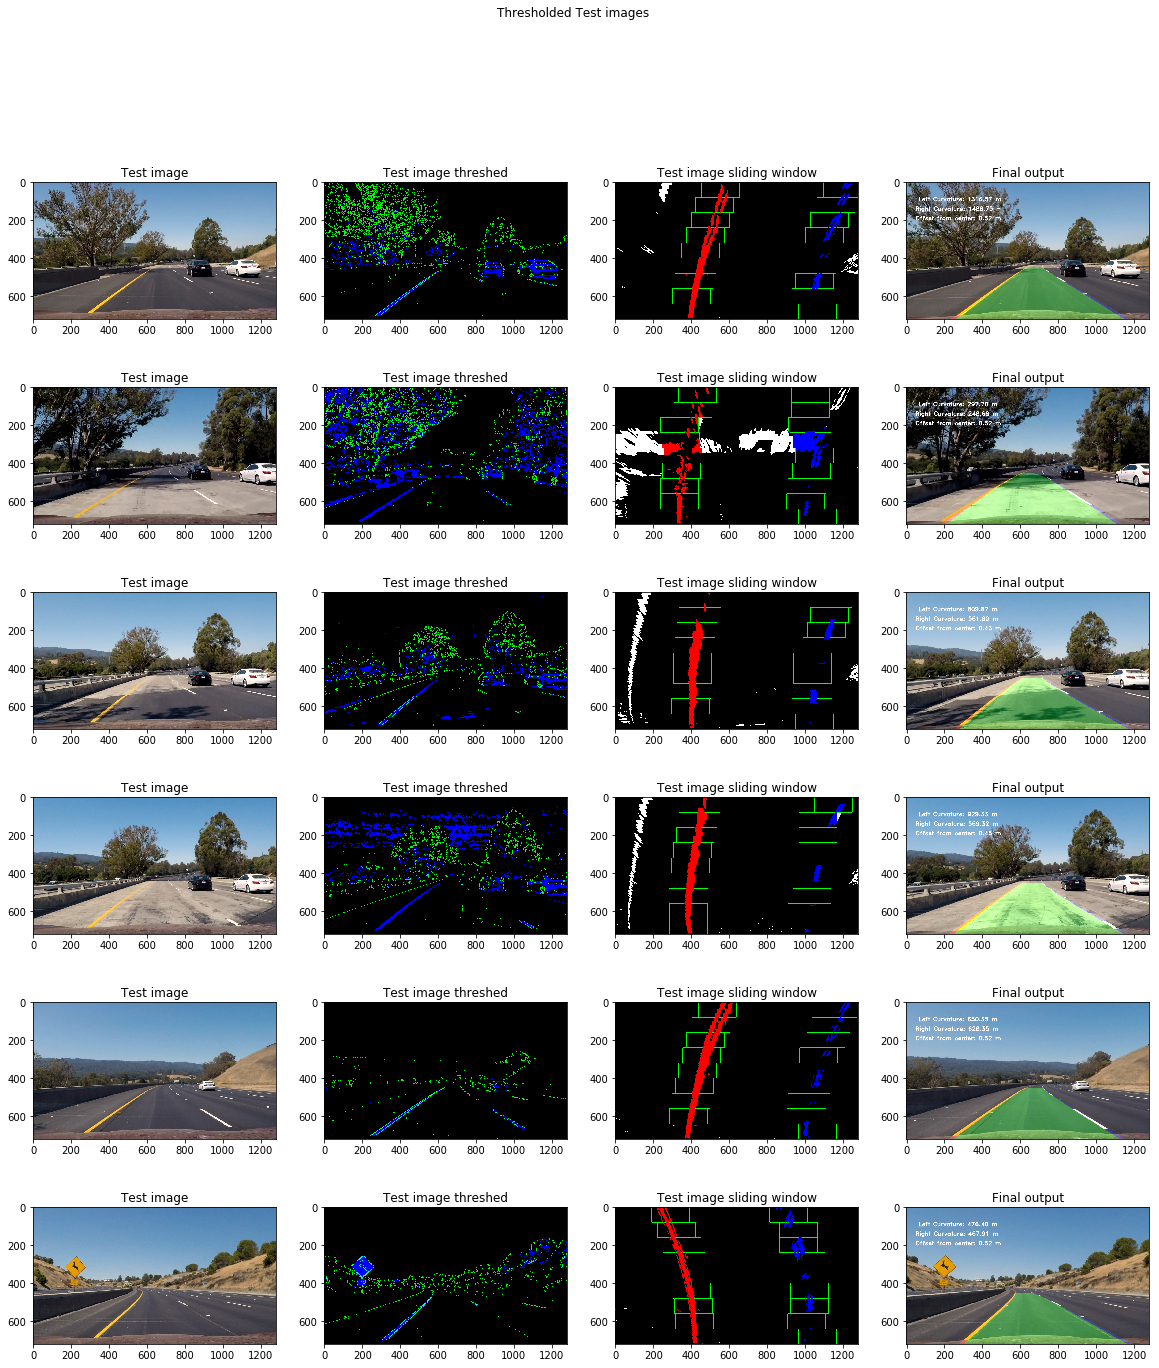

In [6]:
testimg_dir = glob.glob('./test_images/test*.jpg')

test_images = []

for img_dir in testimg_dir:
    test_images.append(mpimg.imread(img_dir))
test_images_threshed = []
test_images_sliding_window = []
test_images_result = []
for img in test_images:
    test_images_result.append(output_pipeline(img))
    test_images_threshed.append(thresh_pipeline(img))
    test_images_sliding_window.append(sliding_window_pipeline(img))
f, axes = plt.subplots(6, 4)
f.set_figheight(22)
f.set_figwidth(20)
f.suptitle('Thresholded Test images')
i = 0
for axe in axes:
    axe[0].imshow(test_images[i])
    axe[0].set_title('Test image')
    axe[1].imshow(test_images_threshed[i], cmap='gray')
    axe[1].set_title('Test image threshed')
    axe[2].imshow(test_images_sliding_window[i])
    axe[2].set_title('Test image sliding window')
    axe[3].imshow(test_images_result[i])
    axe[3].set_title('Final output')
    i += 1

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
input_video_name = 'project_video.mp4'

clip1 = VideoFileClip(input_video_name)
output_video_name = 'project_output'

''' don't modify below '''
# video for lane lines found
white_clip = clip1.fl_image(output_pipeline) #NOTE: this function expects color images!!
output_video = 'output_images/' + output_video_name +'.mp4'
%time white_clip.write_videofile(output_video, audio=False)


clip1 = VideoFileClip(input_video_name)
# video for sliding window image
white_clip = clip1.fl_image(sliding_window_pipeline) #NOTE: this function expects color images!!
window_video = 'output_images/' + output_video_name +'_sliding_window.mp4'
%time white_clip.write_videofile(window_video, audio=False)

clip1 = VideoFileClip(input_video_name)
# video for threshed image
white_clip = clip1.fl_image(thresh_pipeline)
thresh_video = 'output_images/' + output_video_name +'_thresh.mp4'
%time white_clip.write_videofile(thresh_video, audio=False)



[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4


100%|█████████▉| 1260/1261 [03:32<00:00,  4.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 3min 31s, sys: 31.1 s, total: 4min 2s
Wall time: 3min 34s
[MoviePy] >>>> Building video output_images/project_output_sliding_window.mp4
[MoviePy] Writing video output_images/project_output_sliding_window.mp4


100%|█████████▉| 1260/1261 [02:34<00:00,  9.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output_sliding_window.mp4 

CPU times: user 2min 21s, sys: 25.9 s, total: 2min 47s
Wall time: 2min 34s
[MoviePy] >>>> Building video output_images/project_output_thresh.mp4
[MoviePy] Writing video output_images/project_output_thresh.mp4


100%|█████████▉| 1260/1261 [01:53<00:00, 12.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output_thresh.mp4 

CPU times: user 1min 27s, sys: 12.6 s, total: 1min 40s
Wall time: 1min 54s


In [5]:
def output_pipeline(raw_img):
    ''' main pipeline to generate output '''

    undist = cv2.undistort(raw_img, mtx, dist, None, mtx)
    binary_warped = thresh_transform_pipeline(undist, main_pipe=True)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    '''check if the peak changed over 100 pixels'''
    # peak_theta = 80
    if not left_line.detected:
        left_line.detected = True
        right_line.detected = True

        left_line.peak = leftx_base
        right_line.peak = rightx_base

    # if line detected is not reasonable, use previous recorded detection and redo the sliding window search
    if (left_line.best_fit is None) or (np.abs(leftx_base - left_line.peak) >= peak_theta) or (np.abs(rightx_base - right_line.peak) >= peak_theta):
        leftx_base = left_line.peak
        rightx_base = right_line.peak


        # Choose the number of sliding windows
        nwindows = n_windows
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # record this fit
        left_line.best_fit = left_fit
        right_line.best_fit = right_fit

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # the line detected is reasonable
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
#         margin = 100

        left_fit = left_line.best_fit
        right_fit = right_line.best_fit
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # calculate offset using two line x base found
    offset = np.abs(1280/2 - np.mean([leftx_base, rightx_base])) * xm_per_pix
    
    # find curvature
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])    
    


    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw two lane lines in different color
    cv2.polylines(color_warp, np.int32([pts_left]), False, (255,0,0), 15, cv2.LINE_AA)
    cv2.polylines(color_warp, np.int32([pts_right]), False, (0,0,255), 15, cv2.LINE_AA)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image

    undist = np.copy(undist)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # add curvature to the image
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result,' Left Curvature: {:.2f} m'.format(left_curverad), fontFace=font, 
                org=(50,100), fontScale=1, color=(255,255,255),thickness=2, lineType=cv2.LINE_AA)
    cv2.putText(result,'Right Curvature: {:.2f} m'.format(right_curverad), fontFace=font, 
                org=(50,150), fontScale=1, color=(255,255,255),thickness=2, lineType=cv2.LINE_AA)
    cv2.putText(result,'Offset from center: {:.2f} m'.format(offset), fontFace=font,
                org=(50,200), fontScale=1, color=(255,255,255), thickness=2, lineType=cv2.LINE_AA)
    return result


''' Those pipelines are for making corresponding video output '''
def thresh_pipeline(img):
    ''' this pipeline is to generate threshed image for making the video only '''

    img = cv2.undistort(img, mtx, dist, None, mtx)
    # thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 255
#     return combined_binary # someone mentioned videoclip range [0, 255]
    return color_binary

def thresh_transform_pipeline(img, main_pipe=False):
    ''' pipeline to generate threshed and perspective transformed image '''

    # if not called by main pipeline, then the image needed to be undistorted first
    if not main_pipe:
        img = cv2.undistort(img, mtx, dist, None, mtx)
    # thresholding
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Threshold color channel

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    # Perspective transform
    binary_warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]))

    return binary_warped


def sliding_window_pipeline(raw_img):
    ''' pipeline to generate sliding window image '''

    undist = cv2.undistort(raw_img, mtx, dist, None, mtx)
    binary_warped = thresh_transform_pipeline(undist, main_pipe=True)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    '''check if the peak changed over 100 pixels'''
    # peak_theta = 80
    if not left_line.detected:
        left_line.detected = True
        right_line.detected = True

        left_line.peak = leftx_base
        right_line.peak = rightx_base

    # if line detected is not reasonable, use previous recorded detection and redo the sliding window search
    if (left_line.best_fit is None) or (np.abs(leftx_base - left_line.peak) >= peak_theta) or (np.abs(rightx_base - right_line.peak) >= peak_theta):
        leftx_base = left_line.peak
        rightx_base = right_line.peak


    # Choose the number of sliding windows
    nwindows = n_windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    # margin = 100
    # Set minimum number of pixels found to recenter window
    # minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # record this fit
    left_line.best_fit = left_fit
    right_line.best_fit = right_fit

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    


    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img

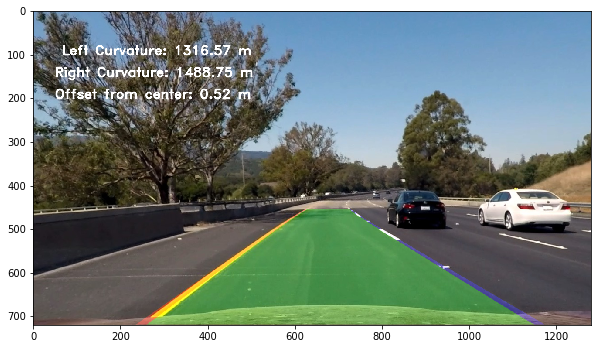

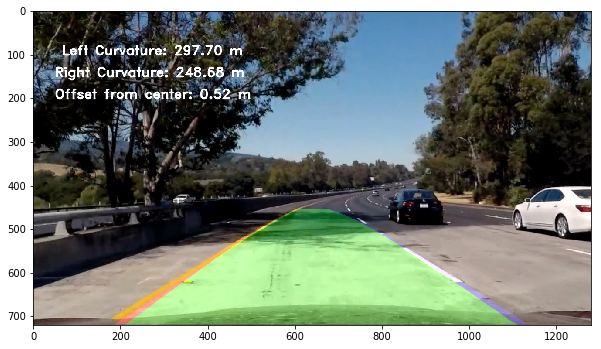

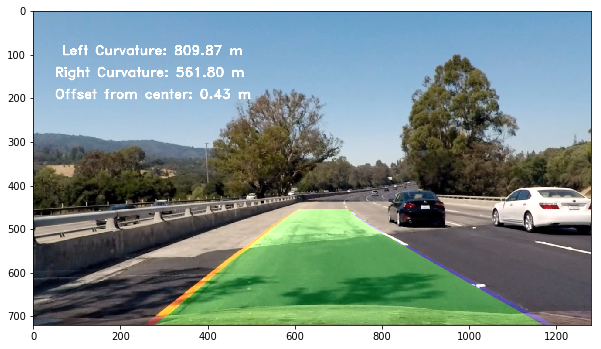

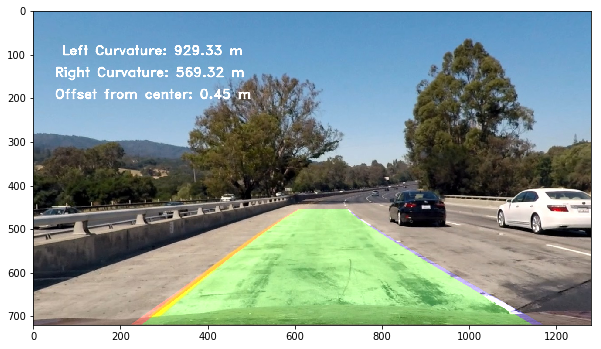

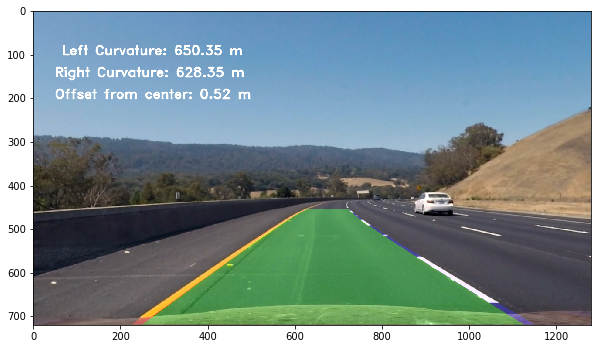

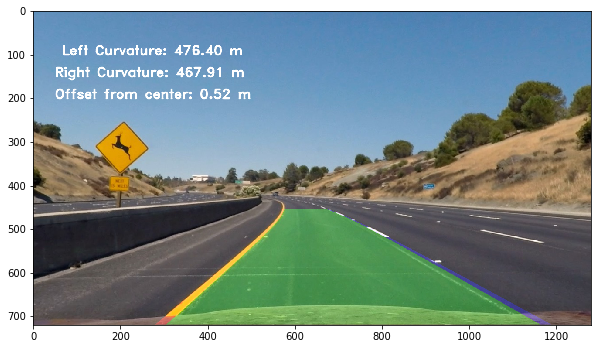

In [12]:
for img in test_images_result:
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()